In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def safelog(x):
    return(np.log(x + 1e-100))

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[+0.0, +2.5],
                        [-2.5, -2.5],
                        [+2.5,-2.0]])
# covariance parameters
class_covariances = np.array([[[+3.2, +0.0], 
                               [+0.0, +1.2]],
                              [[+1.2, +0.8], 
                               [+0.8, +1.2]],
                              [[+1.2, -0.8],
                               [-0.8, +1.2]]])
# sample sizes
class_sizes = np.array([120, 80, 100])

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[2])
X = np.vstack((points1, points2, points3))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

In [4]:
# write data to a file
np.savetxt("hw03_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

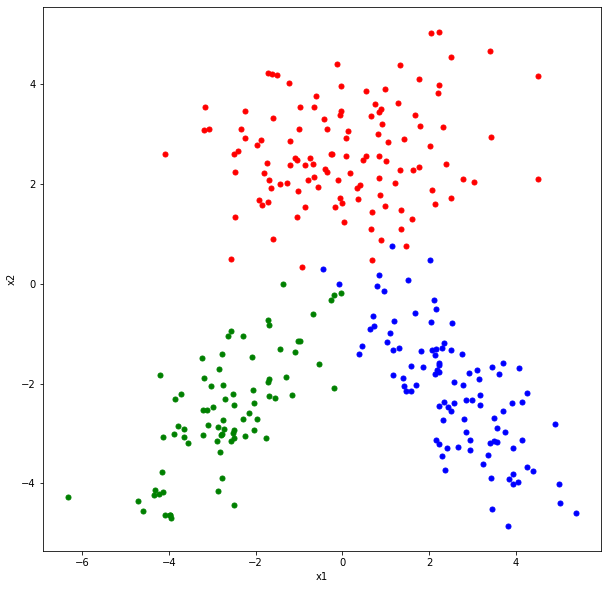

In [5]:
# plot data points generated
plt.figure(figsize = (10, 10))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10)
plt.plot(points2[:,0], points2[:,1], "g.", markersize = 10)
plt.plot(points3[:,0], points3[:,1], "b.", markersize = 10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [6]:
# read data into memory
data_set = np.genfromtxt("hw03_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y_truth)
N = data_set.shape[0]

# one-of-K encoding
Y_truth = np.zeros((N, K)).astype(int)
Y_truth[range(N), y_truth - 1] = 1

In [7]:
# define the sigmoid function
def sigmoid(X, w, w0):
    return(1 / (1 + np.exp(-(np.matmul(X, w) + w0))))

In [11]:
# define the gradient functions
def gradient_W(X, Y_truth, Y_predicted):
    return(np.asarray([-np.matmul((Y_truth[:,c] - Y_predicted[:,c]) * Y_predicted[:,c] * (1 -  Y_predicted[:,c]), X) for c in range(K)]).transpose())

def gradient_w0(Y_truth, Y_predicted):
    return(-np.sum((Y_truth - Y_predicted) * Y_predicted * (1 -  Y_predicted) , axis = 0))

In [12]:
# set learning parameters
eta = 0.01
epsilon = 1e-3

In [13]:
# randomly initalize w and w0
np.random.seed(421)
W = np.random.uniform(low = -0.01, high = 0.01, size = (X.shape[1],K))
w0 = np.random.uniform(low = -0.01, high = 0.01, size = (1,K))

In [14]:
# learn W and w0 using gradient descent
iteration = 1
objective_values = []
while 1:
    Y_predicted = sigmoid(X, W, w0)

    objective_values = np.append(objective_values, (0.5)*np.sum((Y_truth - Y_predicted)**2))

    W_old = W
    w0_old = w0

    W = W - eta * gradient_W(X, Y_truth, Y_predicted)
    w0 = w0 - eta * gradient_w0(Y_truth, Y_predicted)

    if np.sqrt(np.sum((w0 - w0_old))**2 + np.sum((W - W_old)**2)) < epsilon:
        break

    iteration = iteration + 1
print(W)
print(w0)

[[-0.71203284 -2.32222674  2.89641884]
 [ 4.5429135  -2.20965691 -2.47271316]]
[[-1.90068425 -3.61324282 -3.50459445]]


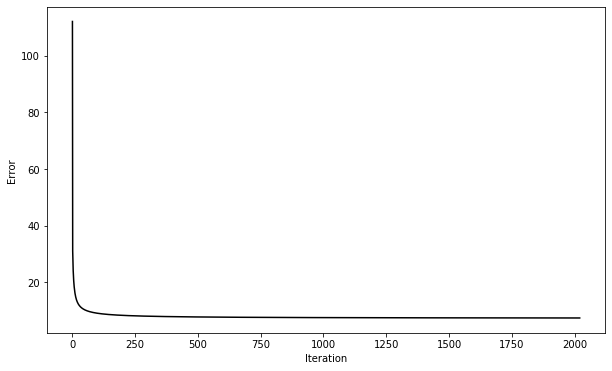

In [15]:
# plot objective function during iterations
plt.figure(figsize = (10, 6))
plt.plot(range(1, iteration + 1), objective_values, "k-")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

In [16]:
# calculate confusion matrix
y_predicted = np.argmax(Y_predicted, axis = 1) + 1
confusion_matrix = pd.crosstab(y_predicted, y_truth, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix)

y_truth    1   2   3
y_pred              
1        120   1   3
2          0  79   0
3          0   0  97


<ipython-input-17-30125297fea9>:13: RuntimeWarning: invalid value encountered in less
  B[(B < A) & (B < C)] = np.nan
<ipython-input-17-30125297fea9>:14: RuntimeWarning: invalid value encountered in less
  C[(C < A) & (C < B)] = np.nan


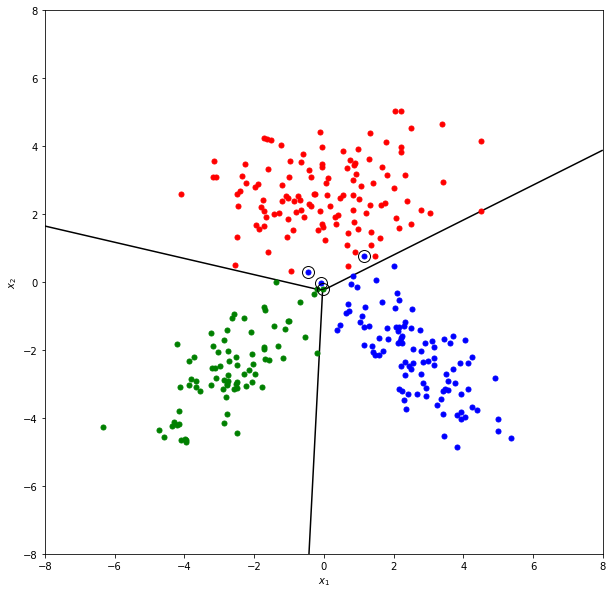

In [17]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-8, +8, 1201)
x2_interval = np.linspace(-8, +8, 1201)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))
for c in range(K):
    discriminant_values[:,:,c] = W[0, c] * x1_grid + W[1, c] * x2_grid + w0[0, c]

A = discriminant_values[:,:,0]
B = discriminant_values[:,:,1]
C = discriminant_values[:,:,2]
A[(A < B) & (A < C)] = np.nan
B[(B < A) & (B < C)] = np.nan
C[(C < A) & (C < B)] = np.nan
discriminant_values[:,:,0] = A
discriminant_values[:,:,1] = B
discriminant_values[:,:,2] = C

plt.figure(figsize = (10, 10))
plt.plot(X[y_truth == 1, 0], X[y_truth == 1, 1], "r.", markersize = 10)
plt.plot(X[y_truth == 2, 0], X[y_truth == 2, 1], "g.", markersize = 10)
plt.plot(X[y_truth == 3, 0], X[y_truth == 3, 1], "b.", markersize = 10)
plt.plot(X[y_predicted != y_truth, 0], X[y_predicted != y_truth, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,1], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,1] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()